# Analysis

In [1]:
cd ..

In [43]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Imports are relative to `clouds/`
from reproduction.pipeline import load as pipeline
from reproduction.analysis import img_scatter
from osgeo import gdal
import os
import tensorflow as tf
from tensorflow.contrib.data import shuffle_and_repeat, batch_and_drop_remainder
from experimental.sample_pipeline import sample_dataset, plot_samples, plot_hists

from matplotlib import pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from sklearn.manifold import TSNE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load Data

In [108]:
dataset = pipeline.load_data(
    data_glob="data/tif2/*.tfrecord",
    shape=(64, 64, 7),
    batch_size=1,
    read_threads=4,
    shuffle_buffer_size=100,
    prefetch=2
)

In [109]:
def filename_contains_fn(substr):
    def fn (fnames, _, __):
        return tf.py_func(lambda fname: substr in fname, [fnames[0]], tf.bool, False)
    return fn
    
    
ds_open = dataset.filter(filename_contains_fn("open-cell"))
ds_closed = dataset.filter(filename_contains_fn("closed-cell"))
ds_other = dataset.filter(filename_contains_fn("background_"))

In [110]:
fields = ["b%d"%(i+1) for i in range(7)]

### Load

In [111]:
samples = sample_dataset(dataset, 10)

In [112]:
all(len(coord) == 1 for _, coord, _ in samples)

True

### Plot

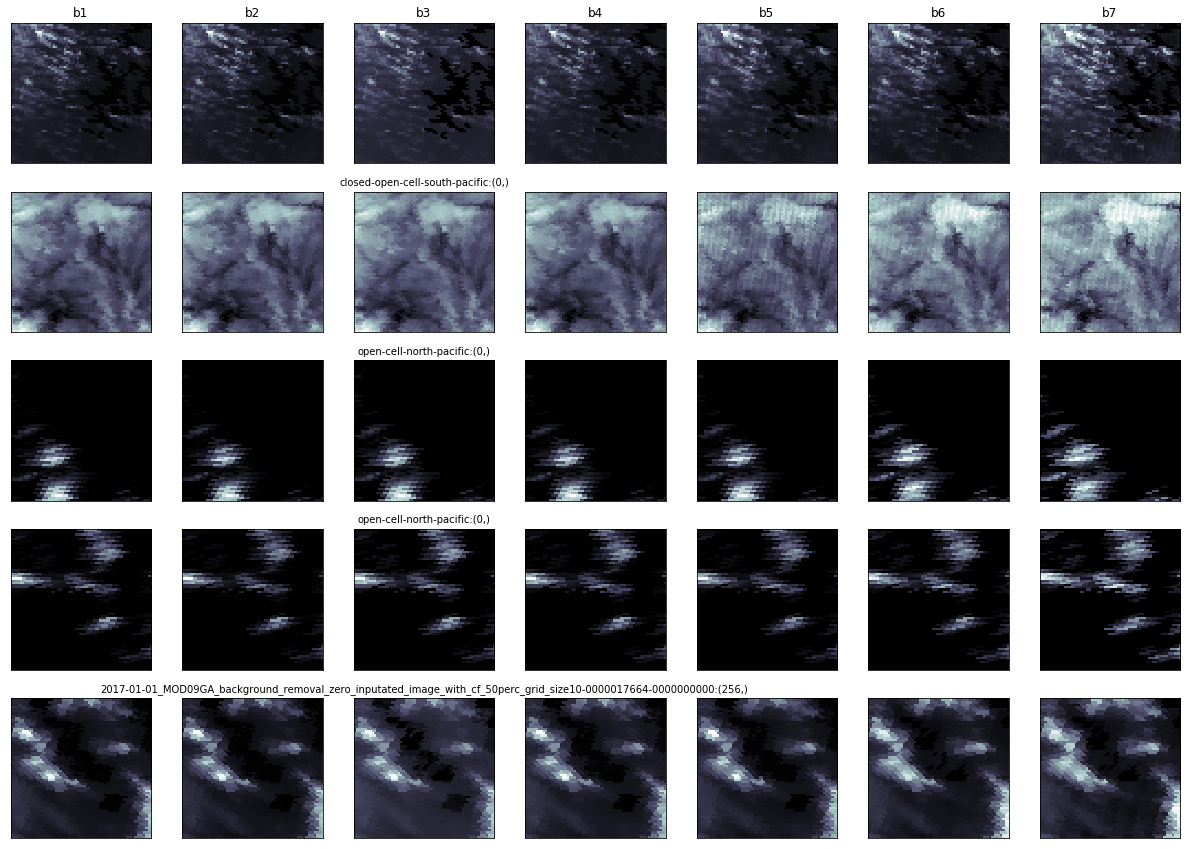

In [113]:
plot_samples(samples[:5], fields);

### Plot histogram of channel distribution

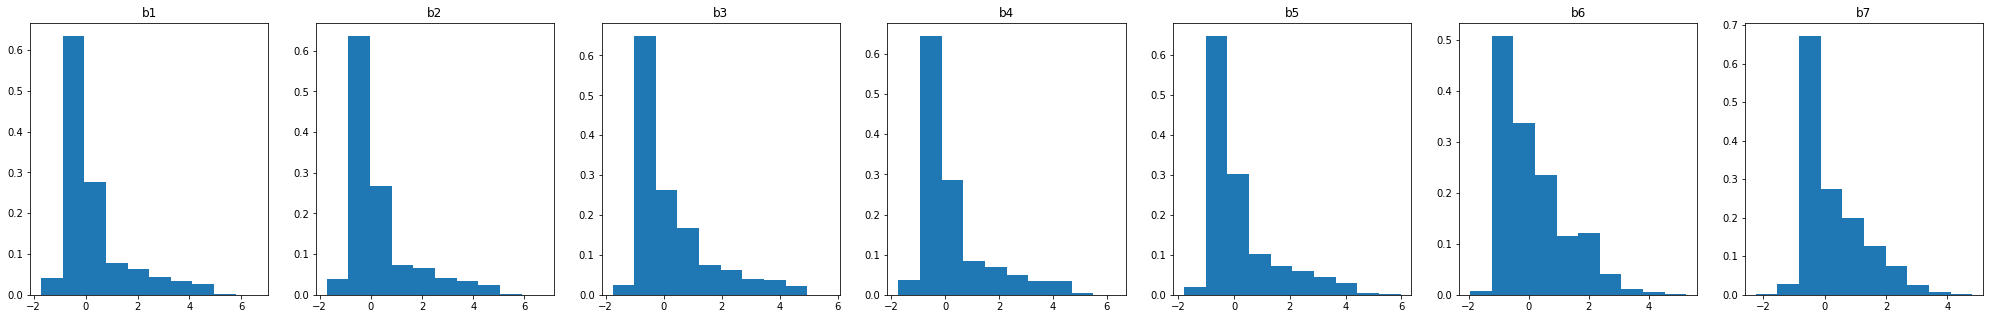

In [114]:
plot_hists(samples, fields);

## Load Model

In [115]:
model_dir = "output/m9/"
!head -n 20 output/m9/run-m9.sbatch_4294967294.out

Tensorflow version: 1.9.0
Current Git Commit: b'fb66c8f'
Flags:
	data:                      ['/project/foster/clouds/geotfr/1_of_8.tfrecords', '/project/foster/clouds/geotfr/2_of_8.tfrecords', '/project/foster/clouds/geotfr/3_of_8.tfrecords', '/project/foster/clouds/geotfr/4_of_8.tfrecords', '/project/foster/clouds/geotfr/5_of_8.tfrecords', '/project/foster/clouds/geotfr/6_of_8.tfrecords', '/project/foster/clouds/geotfr/7_of_8.tfrecords', '/project/foster/clouds/geotfr/8_of_8.tfrecords']
	batch_size:                32
	model_dir:                 out/m9/
	optimizer:                 adam
	steps_per_epoch:           1000
	epochs:                    500
	new_model:                 
	shape:                     (64, 64, 7)
	discriminator:             
	lambda_disc:               0.01
	lambda_gradient_penalty:   10
	n_critic:                  5
	perceptual:                None


Starting epoch 0
Starting epoch 1


In [116]:
with open(model_dir + "ae.json", "r") as f:
    ae = tf.keras.models.model_from_json(f.read())
ae.load_weights(model_dir + "ae.h5")
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ae_input (InputLayer)        (None, 64, 64, 7)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        2048      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         147584    
__________

### Autoencoder output
Each column is a field (labeled), each row triplet of rows is a sample. The triplets are original, difference, and autoencoded

In [130]:
patches = np.stack([p for _, _, p in samples])
patches += 2
patches *= 15000

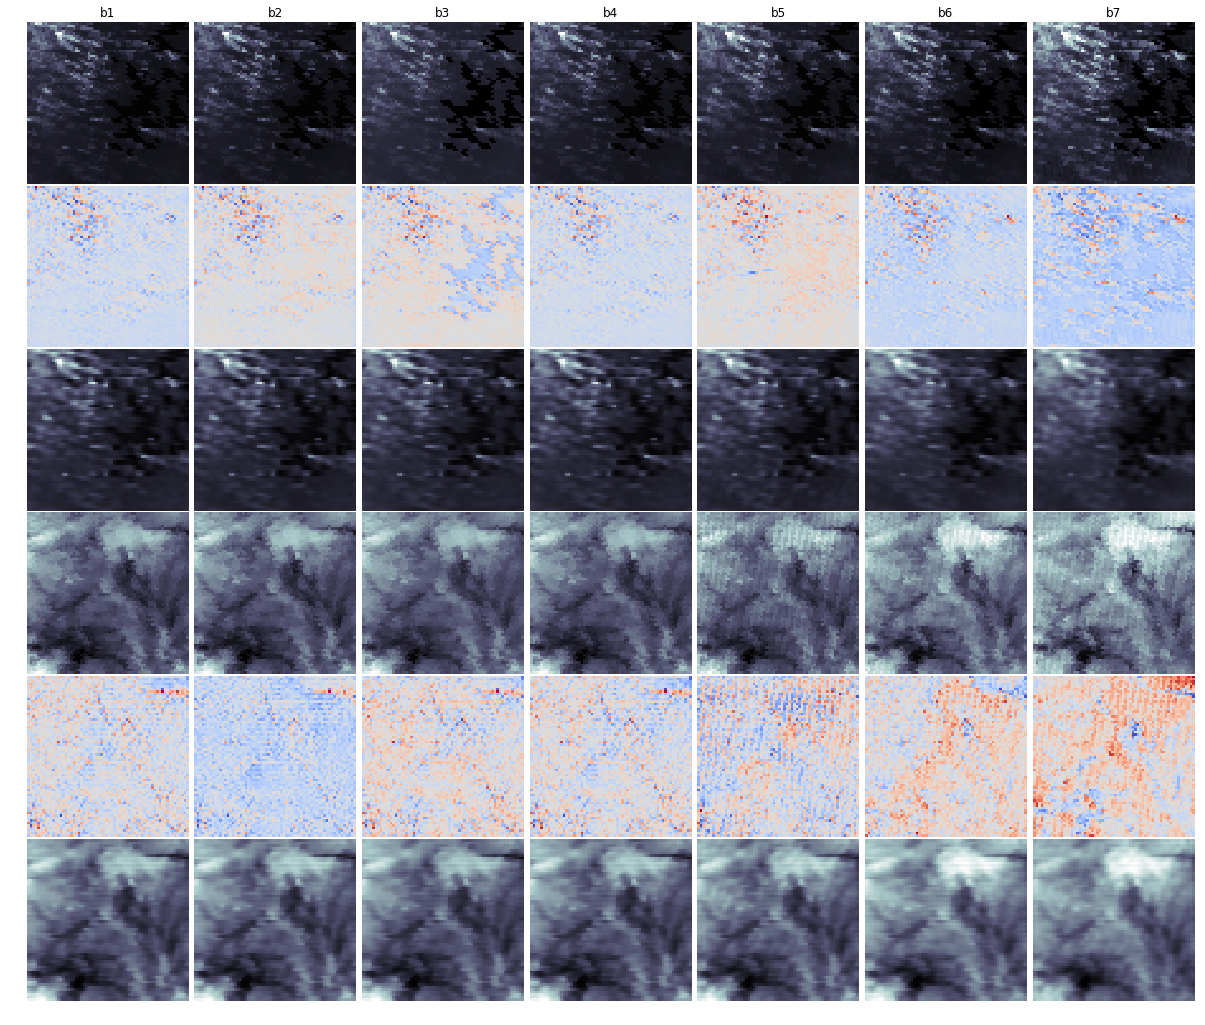

In [131]:
enc, dec = ae.predict(patches.astype(np.float32))

n_samples = 2
width = 3
fig, ax = plt.subplots(
    nrows=n_samples * 3,
    ncols=len(fields),
    figsize=(len(fields) * width, n_samples * width * 3)
)
plt.subplots_adjust(wspace=0.01, hspace=0.01)

for s in range(n_samples):
    for c, field in enumerate(fields):
        orig = ax[s * 3, c]
        orig.imshow(patches[s,:,:, c], cmap="bone")
        if s == 0: orig.set_title(field)
        
        diff = ax[s * 3 + 1, c]
        diff.imshow(patches[s,:,:, c] - dec[s, :, :, c], cmap="coolwarm")
            
        out = ax[s * 3 + 2, c]
        out.imshow(dec[s, :, :, c], cmap="bone")
for a in ax.flatten():
    a.set_axis_off()

## Analysis

### Get more data 

In [177]:
def get_data(dataset, n):
    imgs = []
    x = dataset.make_one_shot_iterator().get_next()
    
    with tf.Session() as sess:
        for _ in range(n // batch_size + 1):
            imgs.append(sess.run(x))

    encodings = []
    for y in imgs:
        enc, _ = ae.predict(y.astype(np.float32))
        encodings.extend(list(enc.mean(axis=(1,2))))

    tmp = []
    for i in imgs:
        tmp.extend(list(i))
    imgs = np.array(tmp)
    encodings = np.array(encodings)
    return imgs, encodings

In [178]:
np.concatenate([cc_enc, oc_enc]).shape

(960, 128)

In [180]:
ot_imgs, ot_enc = get_data(dataset, n=500)
cc_imgs, cc_enc = get_data(closed_cell_dataset, n=500)
oc_imgs, oc_enc = get_data(open_cell_dataset, n=500)

imgs = np.concatenate([ot_imgs, cc_imgs, oc_imgs])
encodings = np.concatenate([ot_enc, cc_enc, oc_enc])

In [193]:
projected = {
    "closed": cc_enc,
    "open": oc_enc,
    "other": ot_enc,
}

for cat in encodings_d:
    projected[cat] -= encodings.mean(axis=0)
    projected[cat] = projected[cat].dot(evecs[:,[0,1,2]]).transpose()

### Compute PCA

In [181]:
centered = encodings - encodings.mean(axis=0)
cov = centered.transpose().dot(centered) / centered.shape[0]
evals, evecs = np.linalg.eigh(cov)
evals = np.flip(evals)
evecs = np.flip(evecs, axis=1)

#### Principle Components and $R^2$

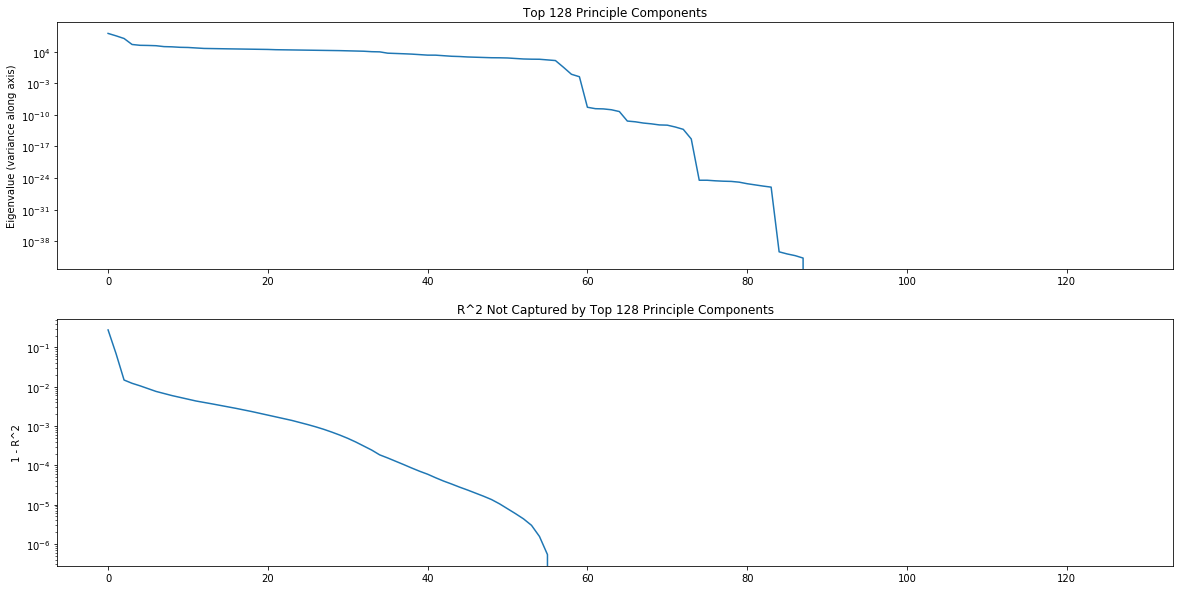

In [188]:
%matplotlib inline
D = 128
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 10))

ax1.plot(evals[:D])
ax1.set_title("Top %d Principle Components"% D)
ax1.set_yscale("log")
ax1.set_ylabel("Eigenvalue (variance along axis)")

ax2.plot(1 - evals.cumsum()[:D] / evals.sum())
ax2.set_title("R^2 Not Captured by Top %d Principle Components"%D)
ax2.set_yscale("log")
ax2.set_ylabel("1 - R^2");

### PCA Projection

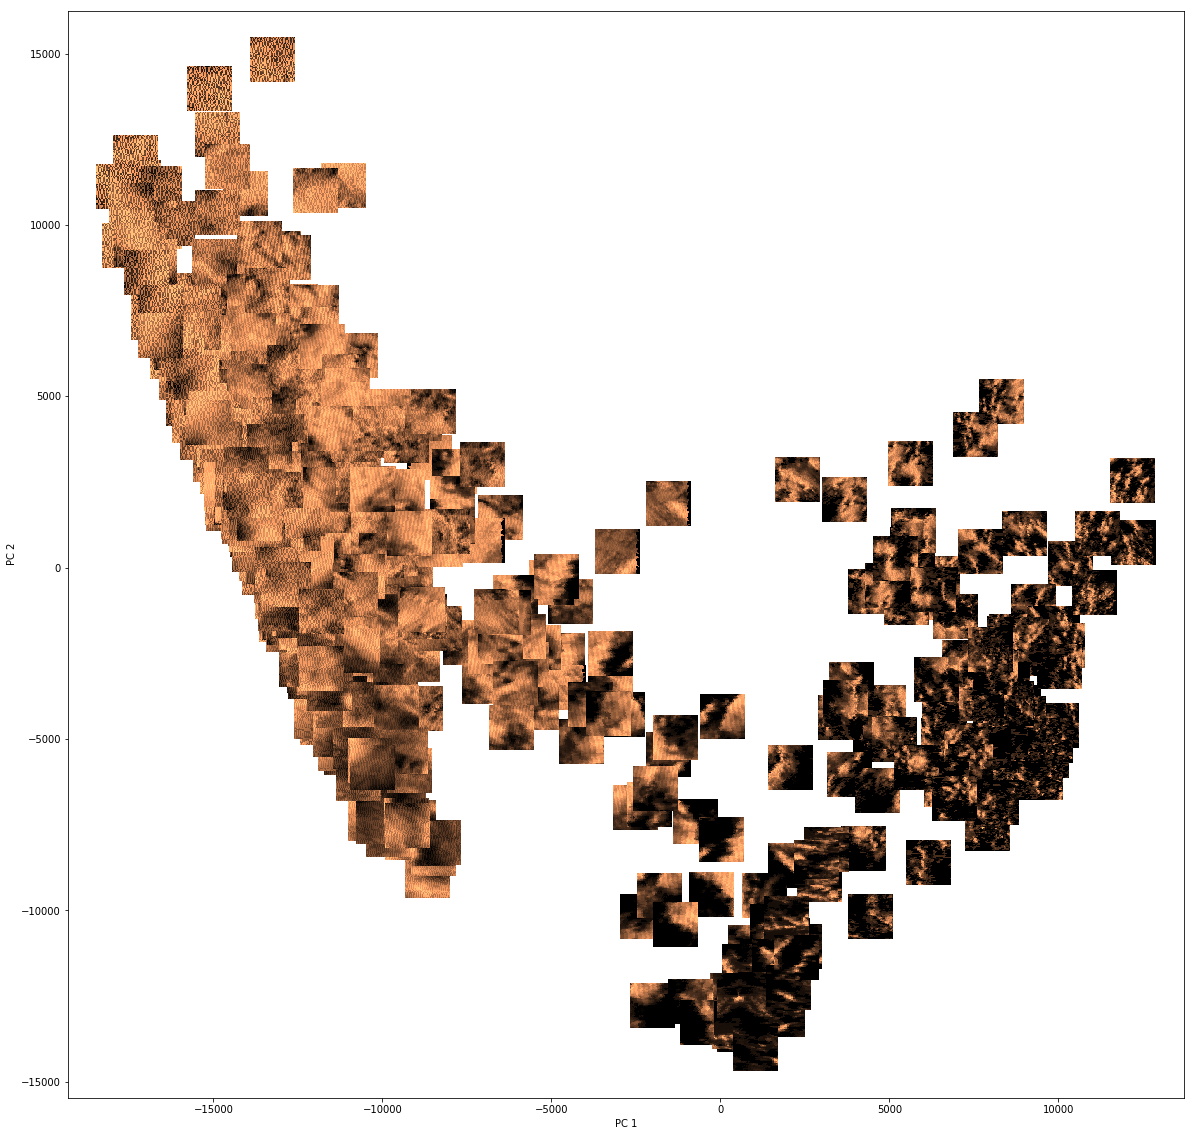

In [185]:
N = 500
# This is zero indexed
dimensions = [0, 1]

projected = centered.dot(evecs[:, dimensions])
fig, ax = img_scatter(
    projected[:N], 
    [y[:,:,4] for y in imgs[:N]],
    zoom=0.7
)
ax.set_xlabel("PC %d"%(dimensions[0] + 1))
ax.set_ylabel("PC %d"%(dimensions[1] + 1));

Text(0.5,0.98,'Three swaths PCA projected')

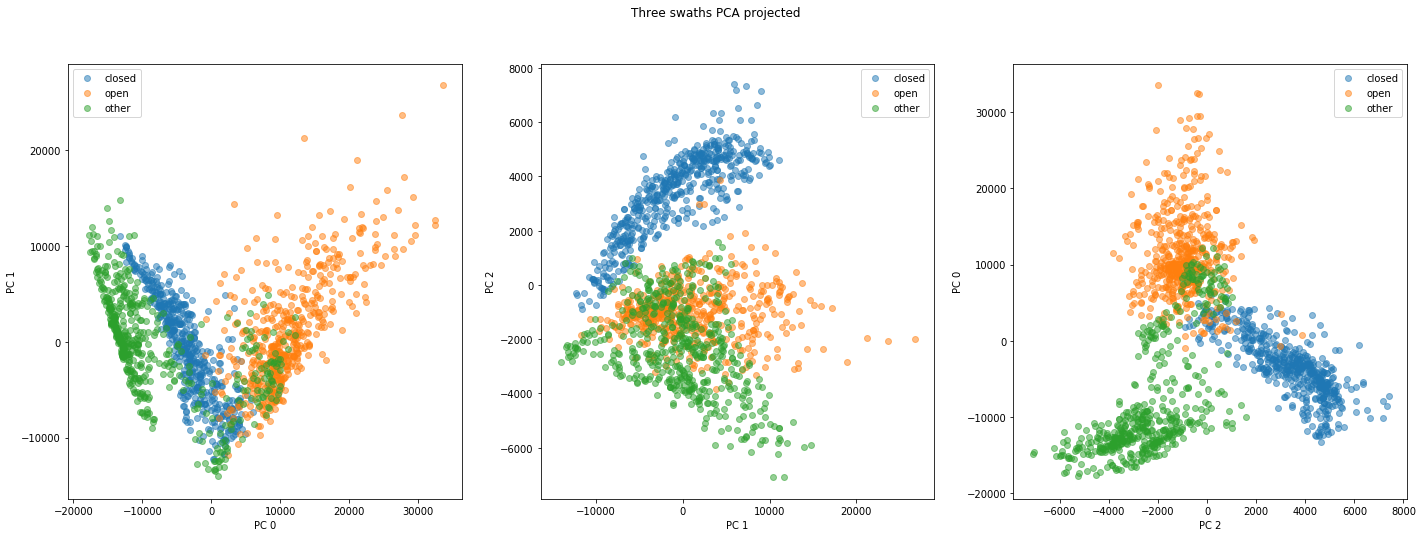

In [197]:
%matplotlib inline
width=8
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(width * 3, width))

for label in projected:
    pcs = projected[label]
    for i in range(3):
        j = (i + 1) % 3
        a = ax[i]
        a.scatter(pcs[i], pcs[j], label=label, alpha=0.5)
        a.set_xlabel("PC %d"%i)
        a.set_ylabel("PC %d"%j)
        a.legend()
        
fig.suptitle("Three swaths PCA projected")

<IPython.core.display.Javascript object>


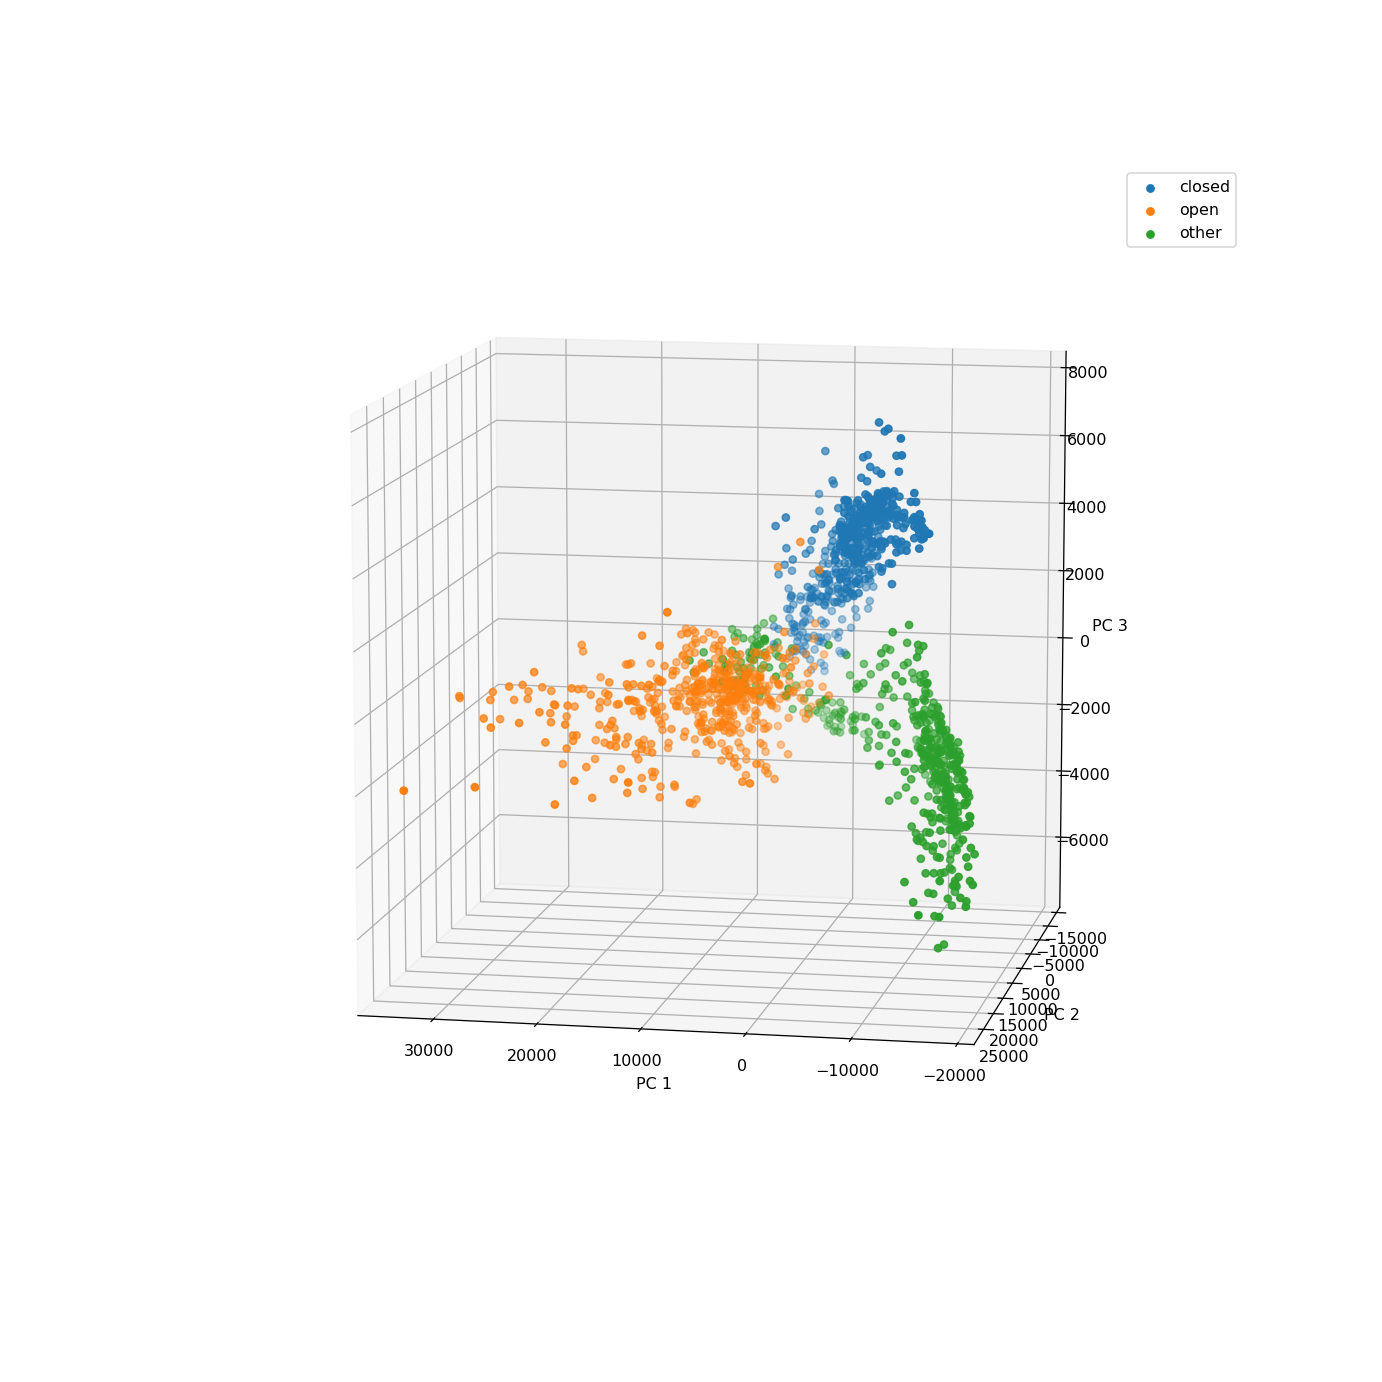

Text(0.5,0,'PC 3')

In [199]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook

dim = (0,1,2)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1, projection='3d')


for label in projected:
    xs_, ys_, zs_ = projected[label]
    ax.scatter(xs_, ys_, zs_, label=label)
ax.legend()

ax.set_xlabel("PC %d"%(dim[0] + 1))
ax.set_ylabel("PC %d"%(dim[1] + 1))
ax.set_zlabel("PC %d"%(dim[2] + 1))

In [200]:
def pc_color(colors, title="", width=8):
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(width * 3, width))
    pc = centered.dot(evecs[:,[0,1,2]]).transpose()
    
    for i in range(3):
        j = (i + 1) % 3
        a = ax[i]
        a.scatter(pc[i], pc[j], c=colors)
        a.set_xlabel("PC %d"%i)
        a.set_ylabel("PC %d"%j)
    fig.suptitle(title)

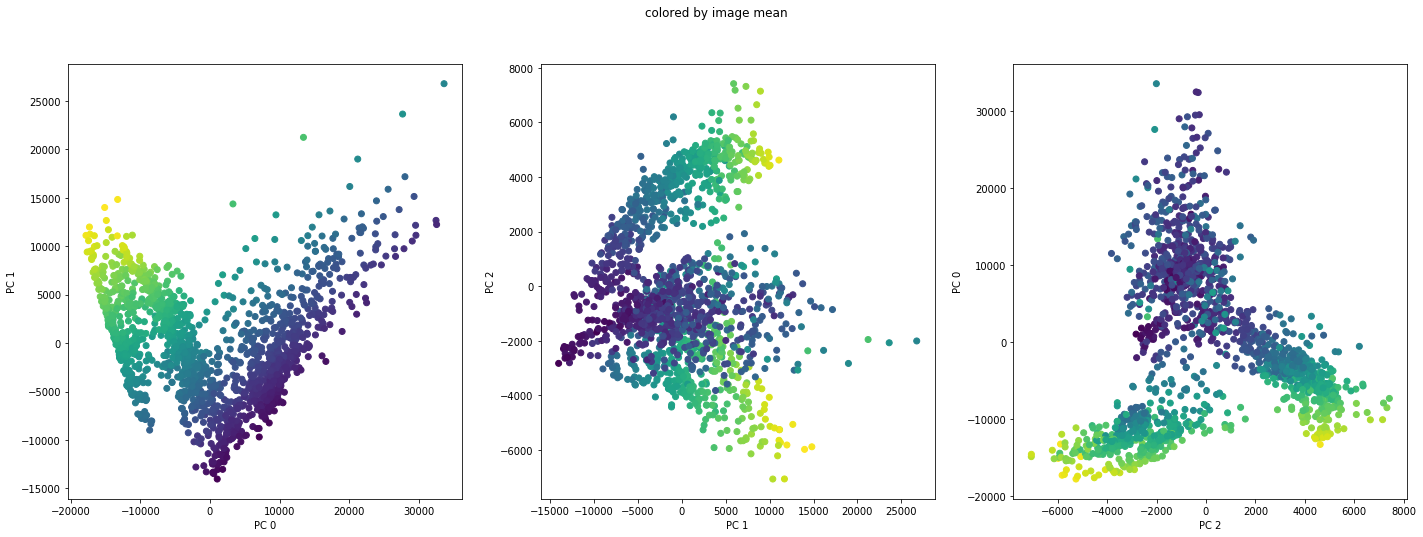

In [201]:
%matplotlib inline
pc_color(imgs.mean(axis=(1,2,3)), "colored by image mean")

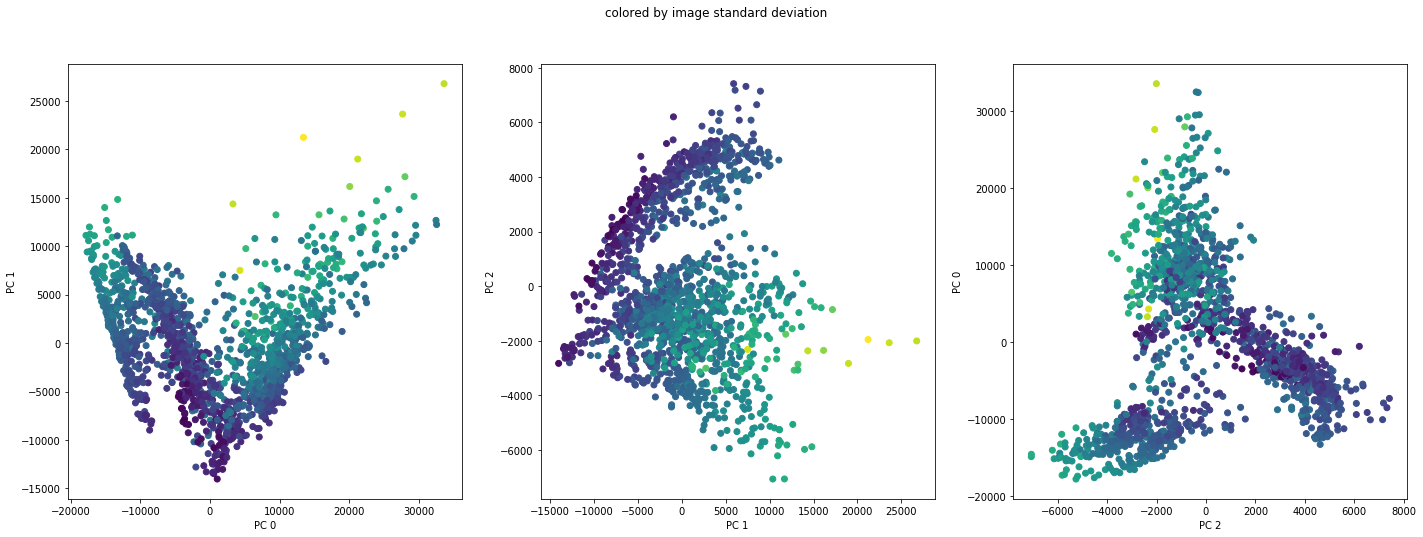

In [202]:
%matplotlib inline
pc_color(imgs.std(axis=(1,2,3)), "colored by image standard deviation")

### T-SNE Projection

In [142]:
N = 500
dims = 50
projected = centered[:N,:].dot(evecs[:, :dims])
embedding = TSNE(n_components=2).fit_transform(projected)

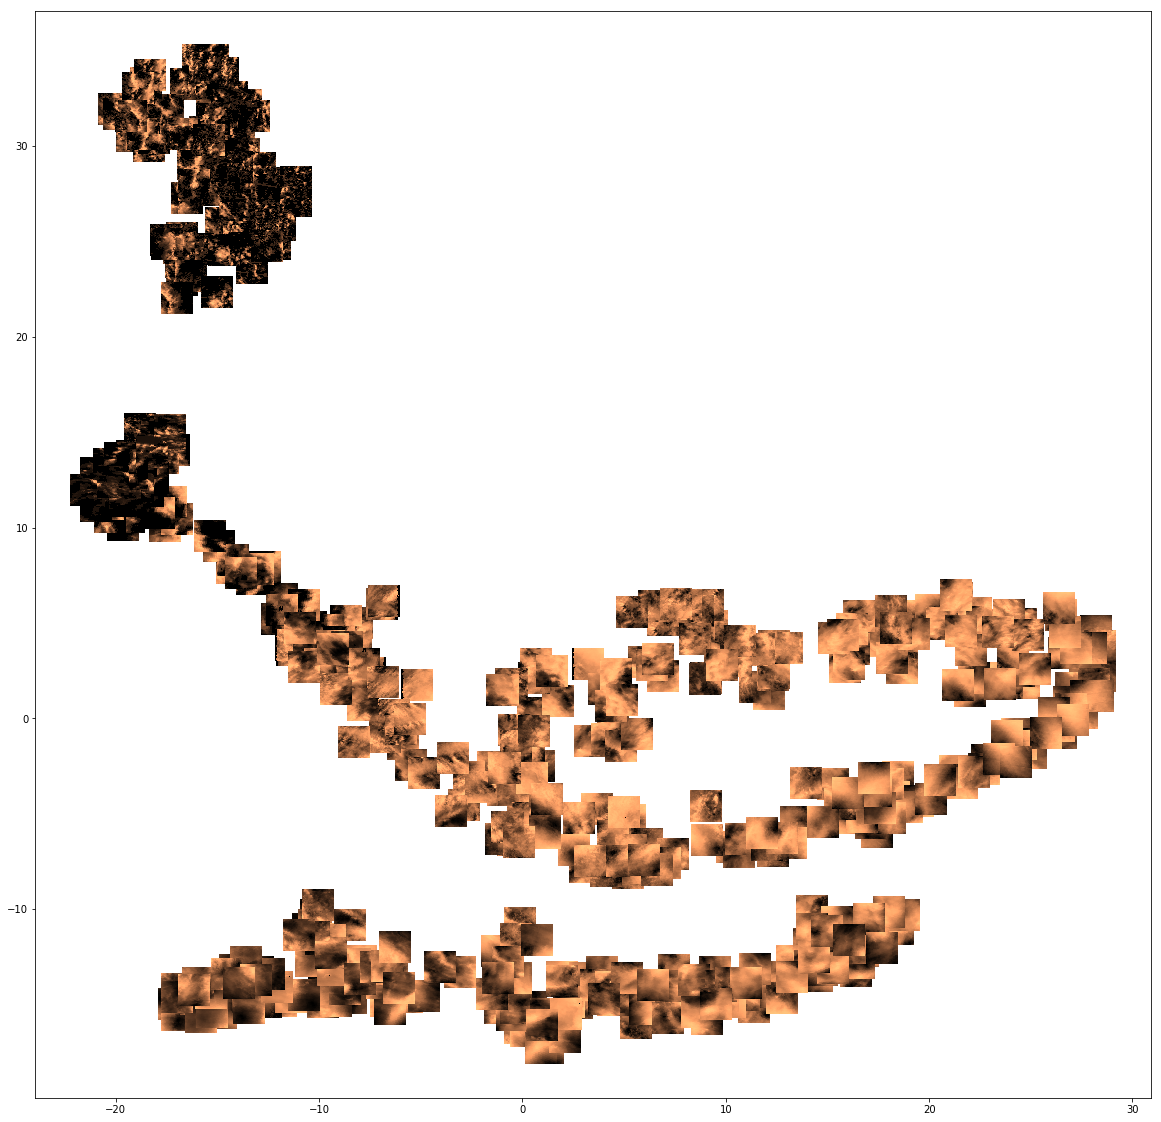

In [143]:
fig, ax = img_scatter(
    embedding,
    [y[:,:,0] for y in imgs[:N]],
)

# Cluster Analysis

In [226]:
from sklearn import cluster
import pandas as pd
from reproduction.analysis import plot_cluster_channel_distributions, plot_cluster_samples

In [227]:
n_clusters = 10
sc = cluster.SpectralClustering(n_clusters, affinity="nearest_neighbors").fit(encodings)
km = cluster.KMeans(n_clusters).fit(encodings)
imgs = np.array(imgs)

In [228]:
def clusterfy(labels):
    n_clusters = len(set(labels))
    clusters = [set() for _ in range(n_clusters)]
    for i, l in enumerate(labels):
        clusters[l].add(i)
    return clusters

def jaccard_similarity(s1, s2):
    return len(s1 & s2) / len(s1 | s2)

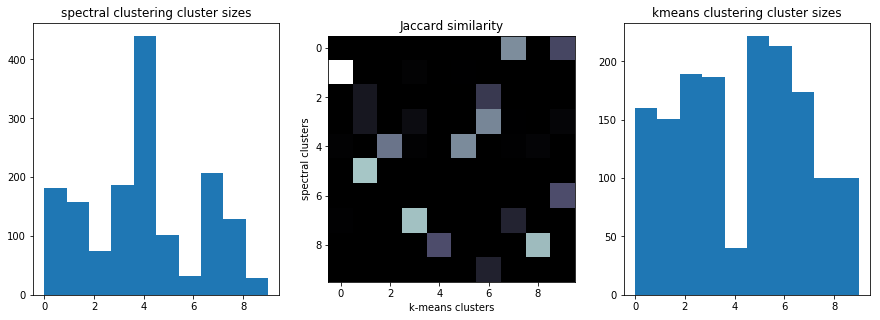

In [229]:
%matplotlib inline
fig, (a, b, c) = plt.subplots(ncols=3, figsize=(15,5))
a.hist(sc.labels_)
a.set_title("spectral clustering cluster sizes")
c.hist(km.labels_);
c.set_title("kmeans clustering cluster sizes")

c1s = clusterfy(sc.labels_)
c2s = clusterfy(km.labels_)
jsims = np.zeros((len(c1s), len(c2s)))
for i, c1 in enumerate(c1s):
    for j, c2 in enumerate(c2s):
        jsims[i, j] =  jaccard_similarity(c1, c2)
        
b.set_ylabel("spectral clusters")
b.set_xlabel("k-means clusters")
b.set_title("Jaccard similarity")
b.imshow(jsims, cmap="bone");

Jaccard similarity is defined $Sim(A,B) = \frac{|A\cap B|}{|A\cup B|}$ so the center matrix corresponds to how similar the clusters are between the two clustering methods. Ideally, the clusters would have a 1 to 1 correspondence and we'd see a single white square for every row and column

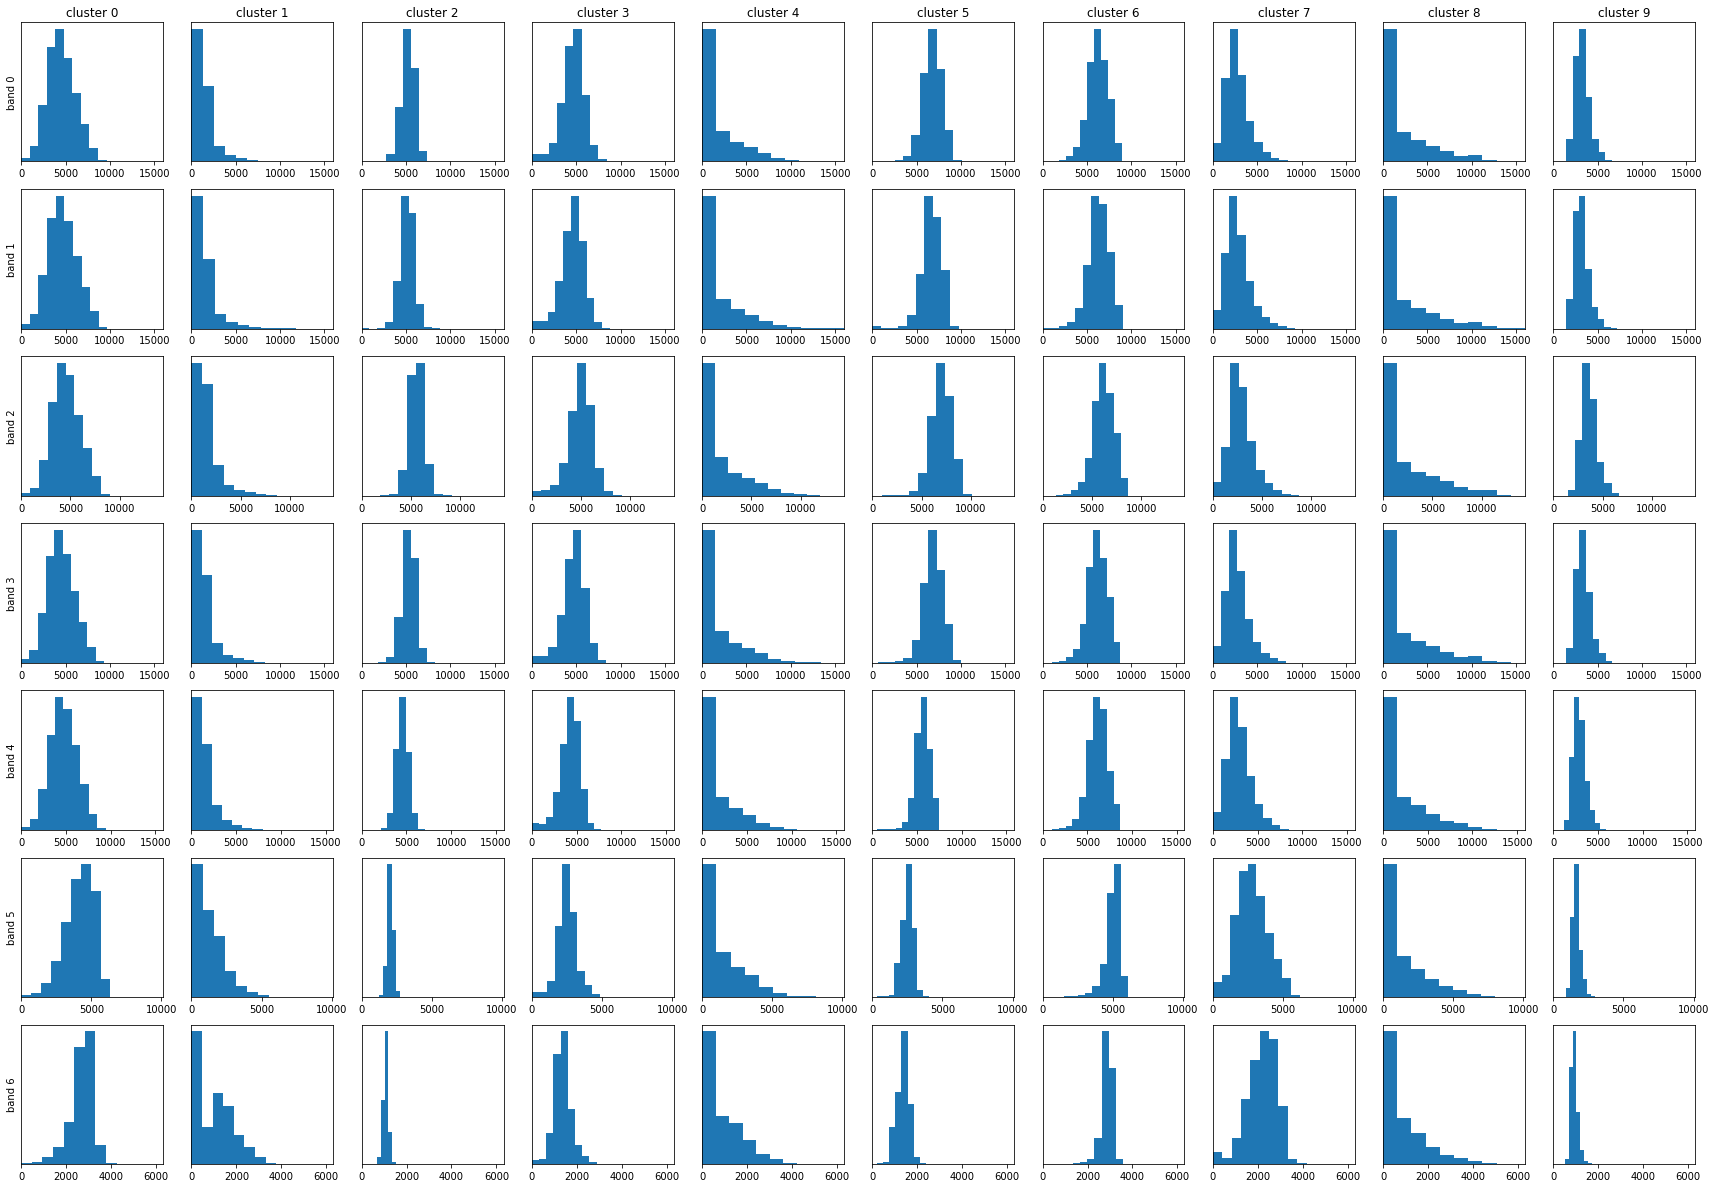

In [230]:
fig, ax = plot_cluster_channel_distributions(imgs, sc.labels_)

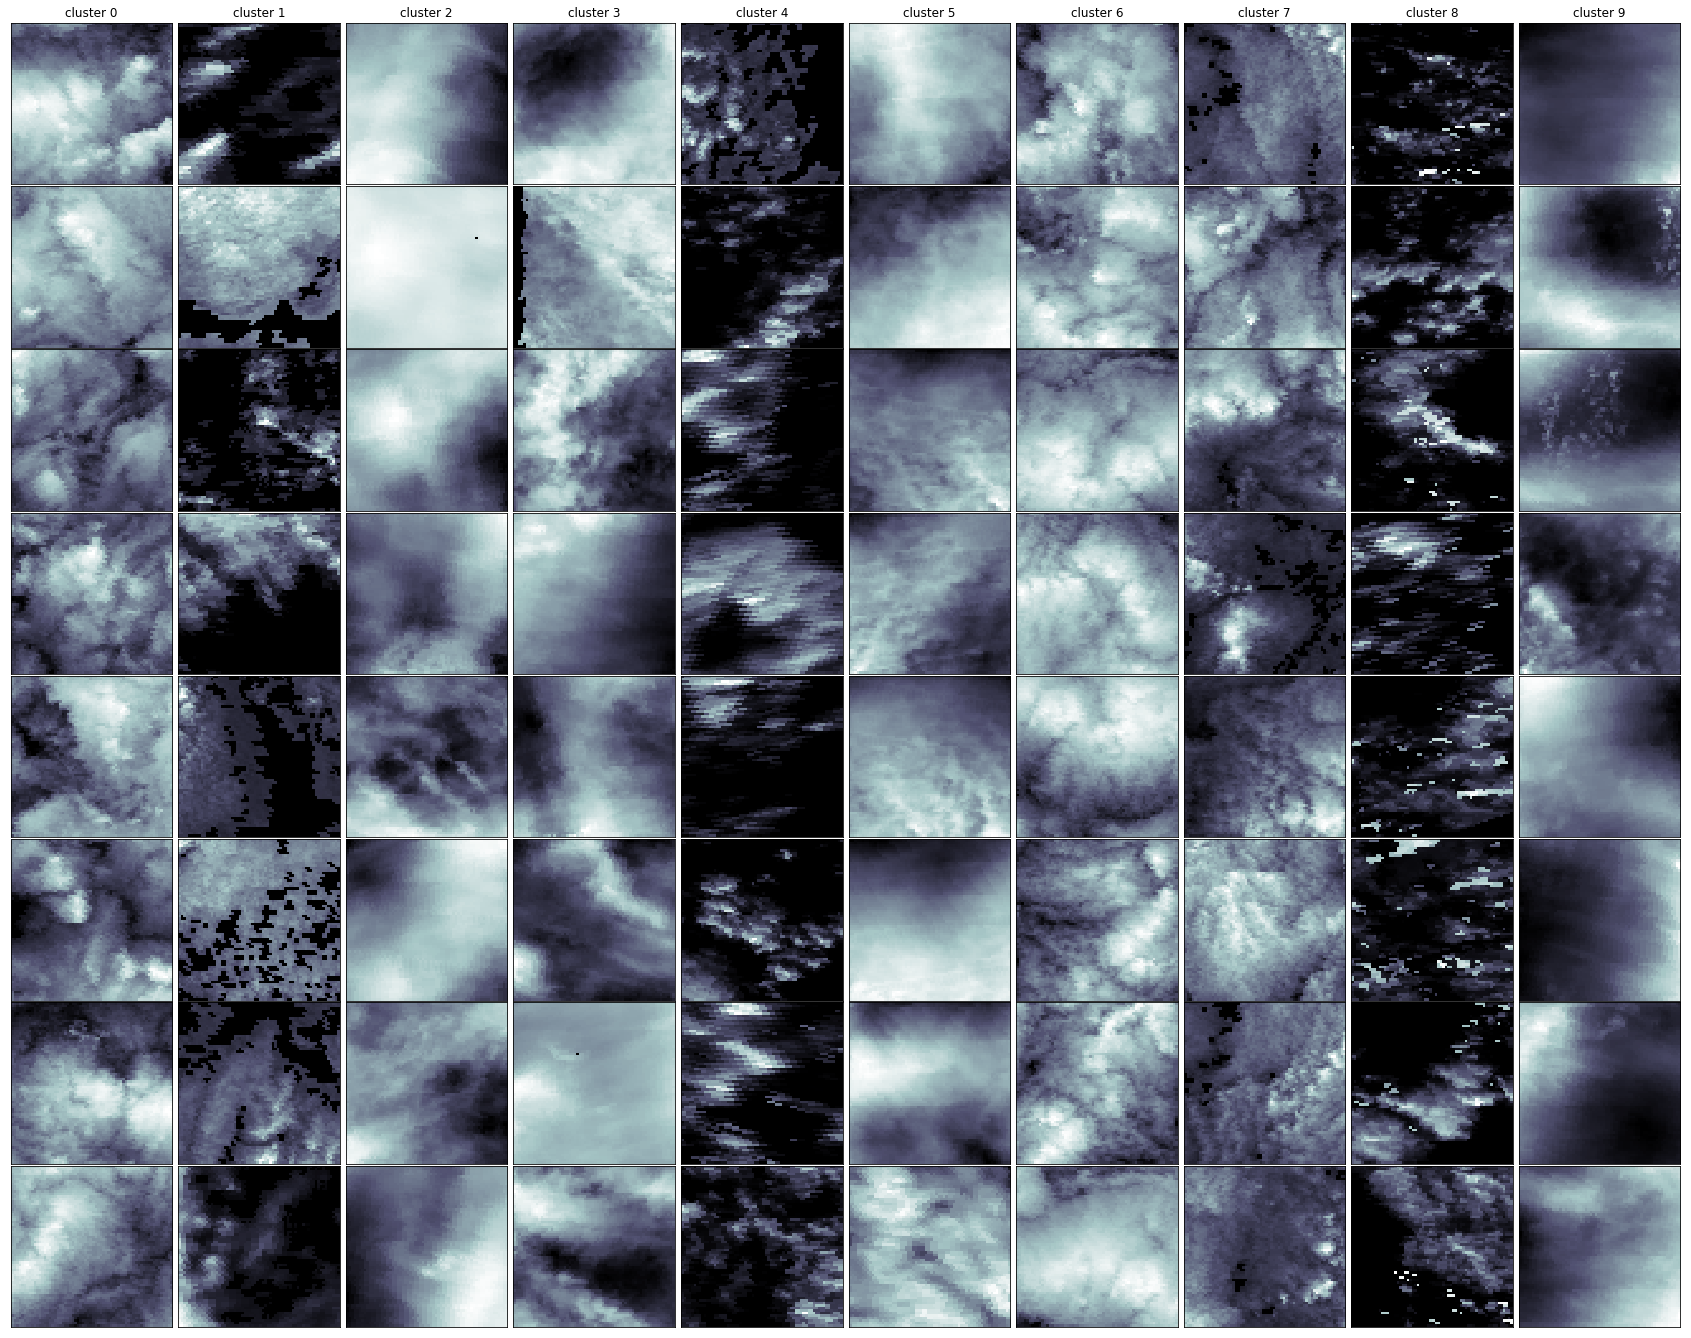

In [231]:
%matplotlib inline
fig, ax = plot_cluster_samples(imgs, sc.labels_)

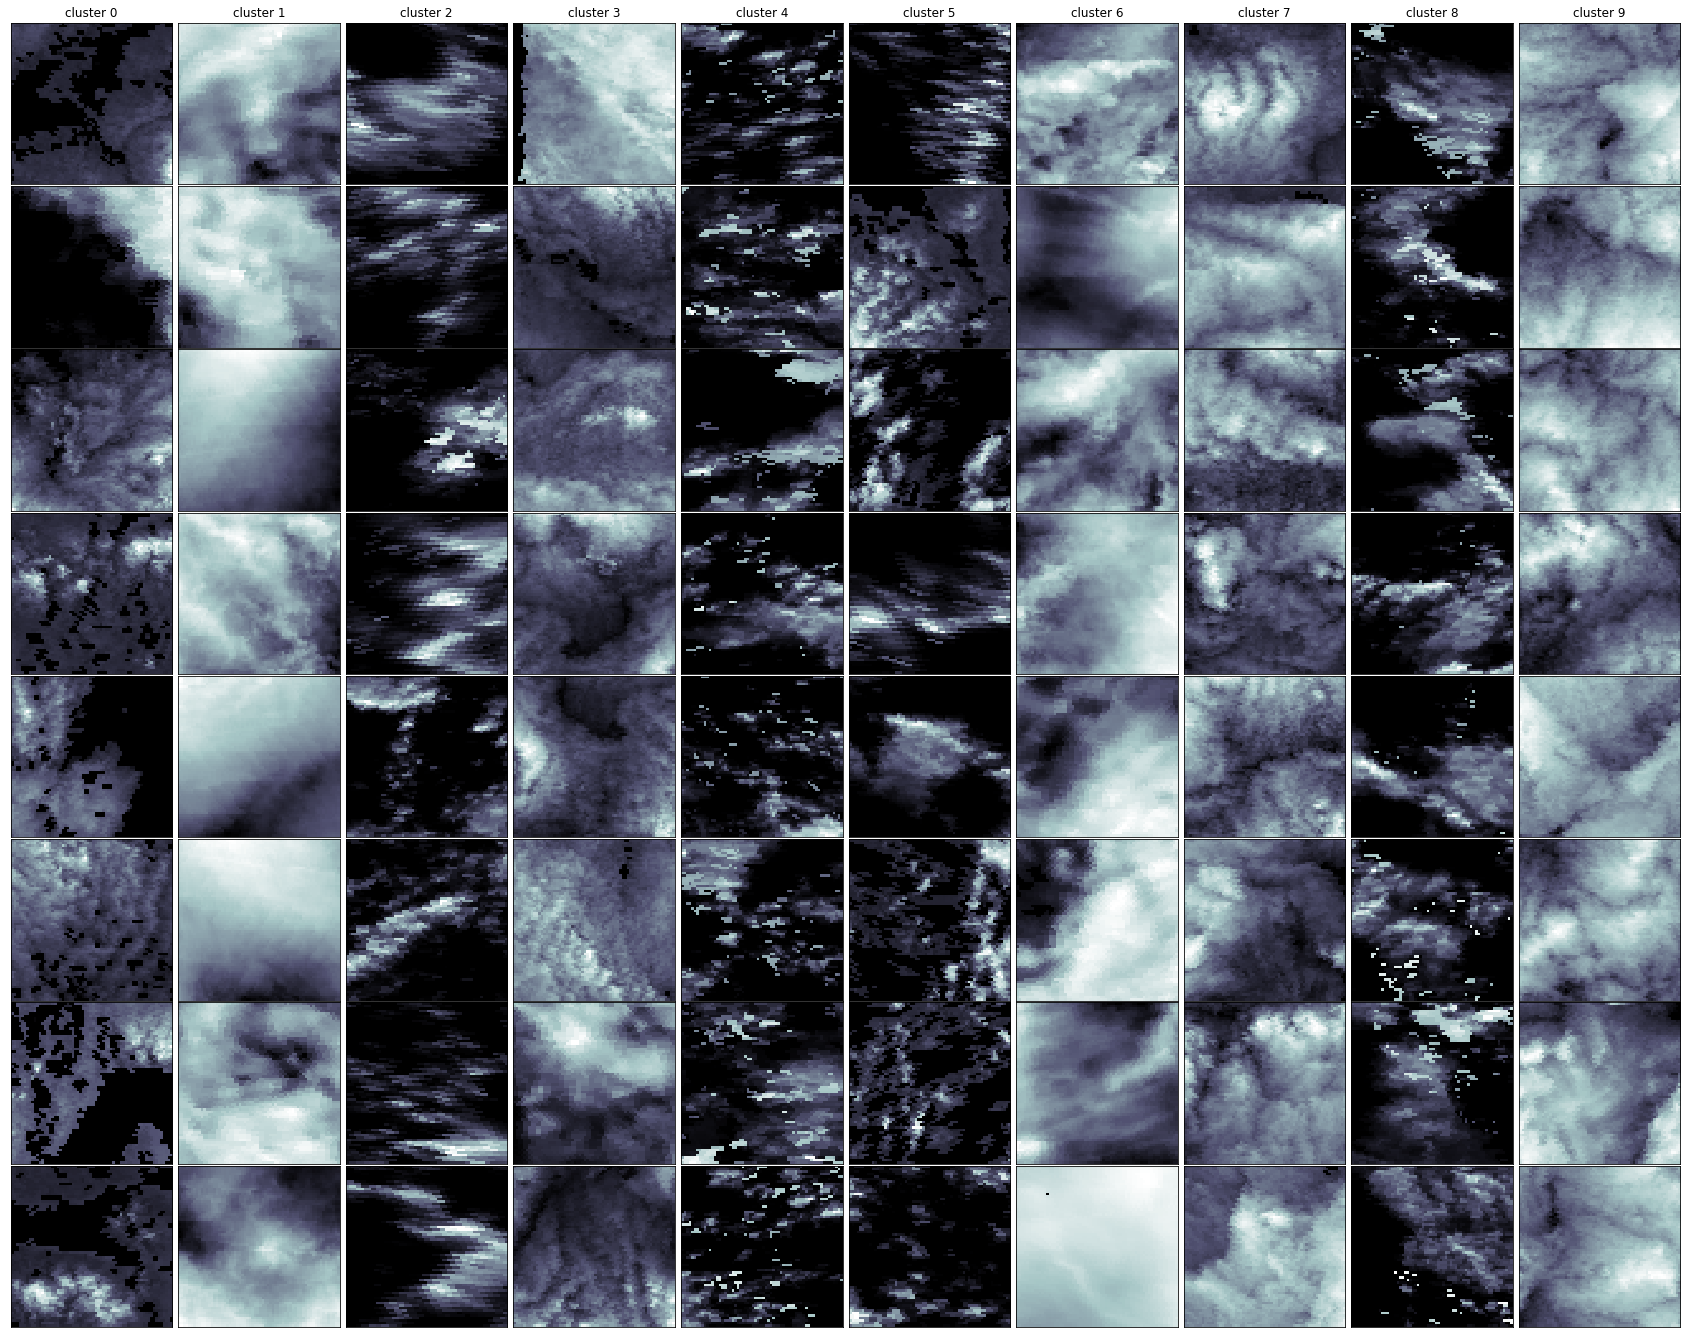

In [232]:
%matplotlib inline
fig, ax = plot_cluster_samples(imgs, km.labels_)


In [151]:
np.unique(sc.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([618, 317, 524, 193, 435,  20, 271, 360, 252, 210]))

<IPython.core.display.Javascript object>


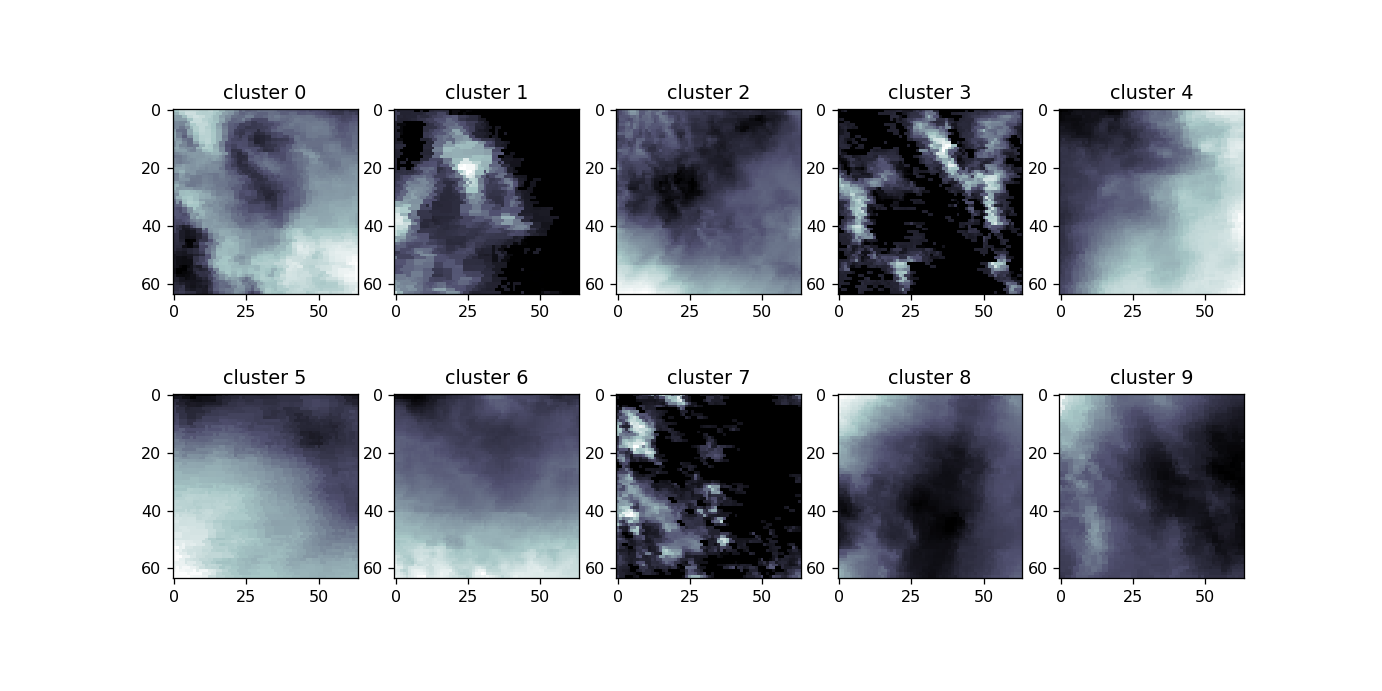

In [166]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook

num_frames = 30
channel = 0
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
ax = ax.ravel()
clusters = [imgs[sc.labels_ == i] for i in range(n_clusters)]

#set up list of images for animation
ims=[]
for time in range(num_frames):
    im = []
    for c in range(n_clusters):
        a = ax[c]
        a.set_title("cluster %d"%c)
        
        size = clusters[c].shape[0]
        img = clusters[c][time % size, :, :, channel]
        
        im.append(a.imshow(img, cmap="bone"))
    
    ims.append(im)

#run animation
ani = animation.ArtistAnimation(fig, ims, interval=500,blit=False)
plt.show()

<IPython.core.display.Javascript object>


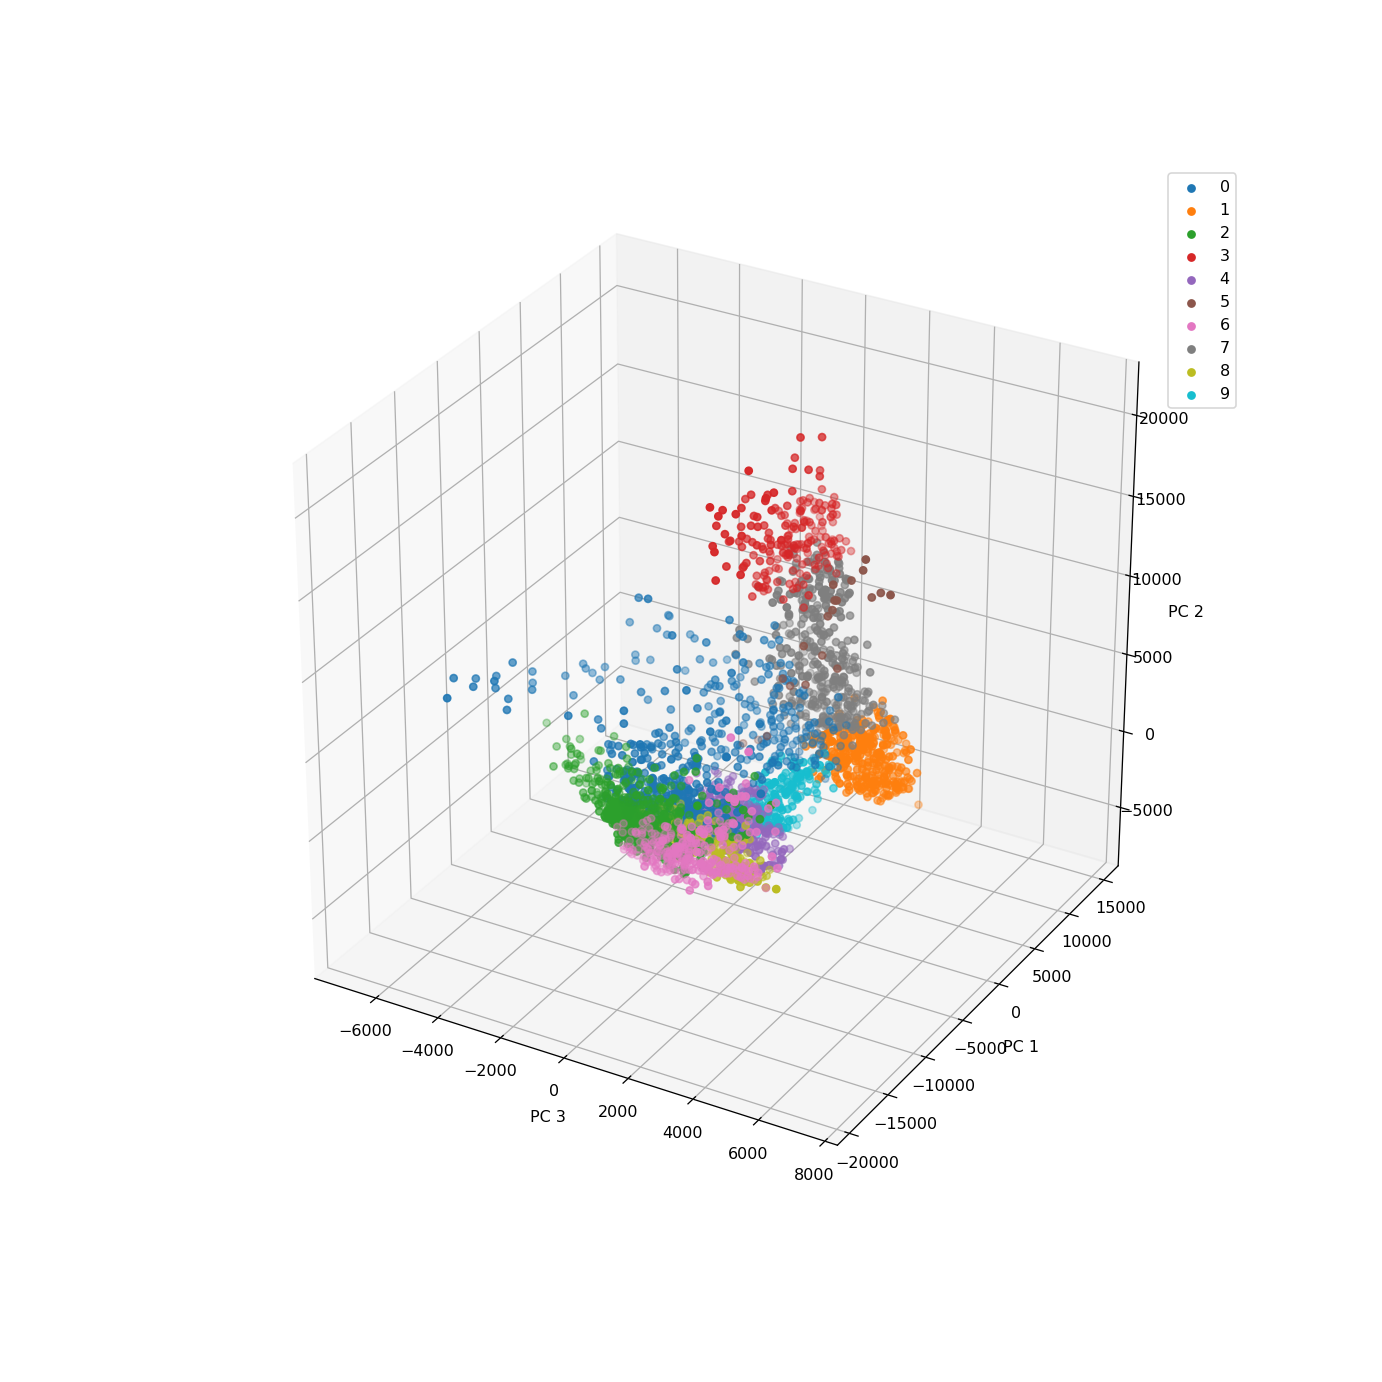

Text(0.5,0,'PC 2')

In [165]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook


dim = (2,0,1)
labels = sc.labels_

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1, projection='3d')

xs_, ys_, zs_ = centered.dot(evecs[:,dim]).transpose()

for l in np.unique(labels):
    i = np.where(labels == l)
    ax.scatter(xs_[i], ys_[i], zs_[i], label=l)
ax.legend()

ax.set_xlabel("PC %d"%(dim[0] + 1))
ax.set_ylabel("PC %d"%(dim[1] + 1))
ax.set_zlabel("PC %d"%(dim[2] + 1))

Looking at the PCA projection, it seems the AE does not seperate different cloud types but rather embeds most kinds of clouds into a single manifold, this perhaps rules out density based clustering techniques

In [154]:
imgs.shape

(3200, 64, 64, 7)

In [155]:
imgs.mean(axis=0).shape

(64, 64, 7)

Text(0.5,0,'PC 2')

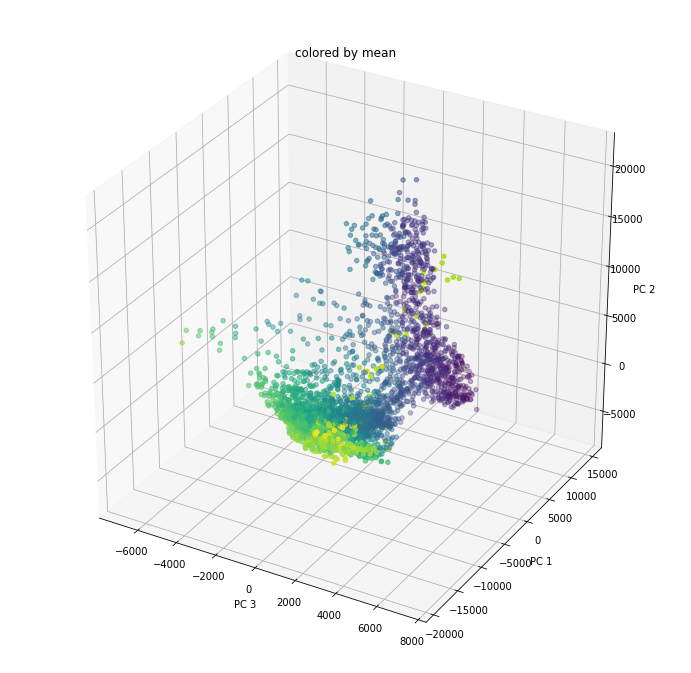

In [164]:
dim = (2,0,1)
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1, projection='3d')

xs_, ys_, zs_ = centered.dot(evecs[:,dim]).transpose()
ax.set_title("colored by mean")
ax.scatter(xs_, ys_, zs_, c=imgs.mean(axis=(1,2,3)))
ax.set_xlabel("PC %d"%(dim[0] + 1))
ax.set_ylabel("PC %d"%(dim[1] + 1))
ax.set_zlabel("PC %d"%(dim[2] + 1))

### Cluster similarity Analysis

### Interpolation

In [157]:
decoder = tf.keras.models.Sequential()
for l in ae.layers[7:]:
    decoder.add(l)

In [158]:
cluster1 = imgs[sc.labels_ == 2]
hid1, enc1 = ae.predict(cluster1[[0]])
hid2, enc2 = ae.predict(cluster1[[1]])

In [159]:
def interpolate(x, y, num=100):
    return [(1 - z) * x + z * y for z in np.linspace(0,1,100)]

def draw_frame(ax, img, title, cmap="bone", channel=0):
    im = ax.imshow(img[0,:,:,channel], cmap=cmap)
    ax.set_title(title)
    return im

<IPython.core.display.Javascript object>


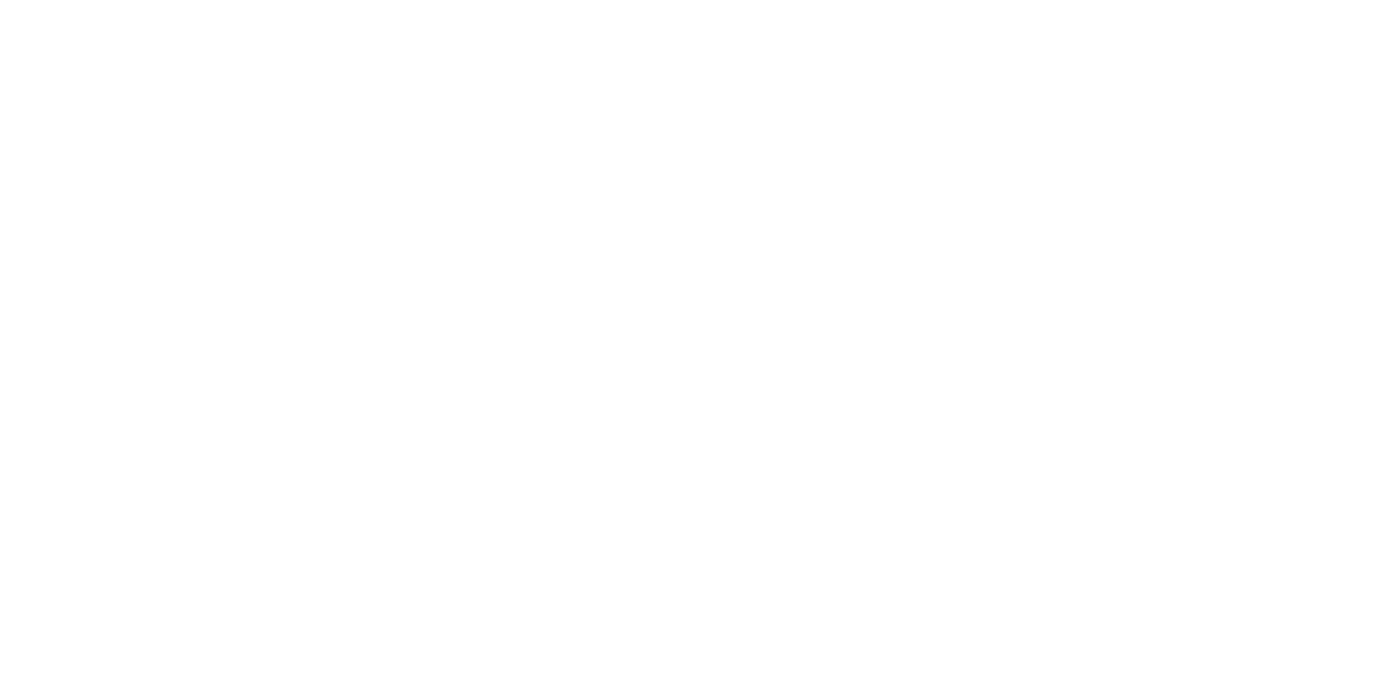

In [160]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
# No joke repeating those ^^ prevents some matplotlib / jupyter error

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))

pixel_interpolation = interpolate(enc1, enc2)
encoded_interpolation = (decoder.predict(h) for h in interpolate(hid1, hid2))
pframes = [draw_frame(ax2, i, "pixel space interpolation") for i in pixel_interpolation]
eframes = [draw_frame(ax1, i, "hidden space interpolation") for i in encoded_interpolation]
ims = list(zip(pframes, eframes))

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=100)

if False: #save
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
    ani.save('interpolation.mp4', writer=writer)


### Interpolation walk through a cluster

Traceback (most recent call last):
  File "/anaconda3/envs/clouds/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/anaconda3/envs/clouds/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/anaconda3/envs/clouds/lib/python3.6/site-packages/matplotlib/animation.py", line 1499, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


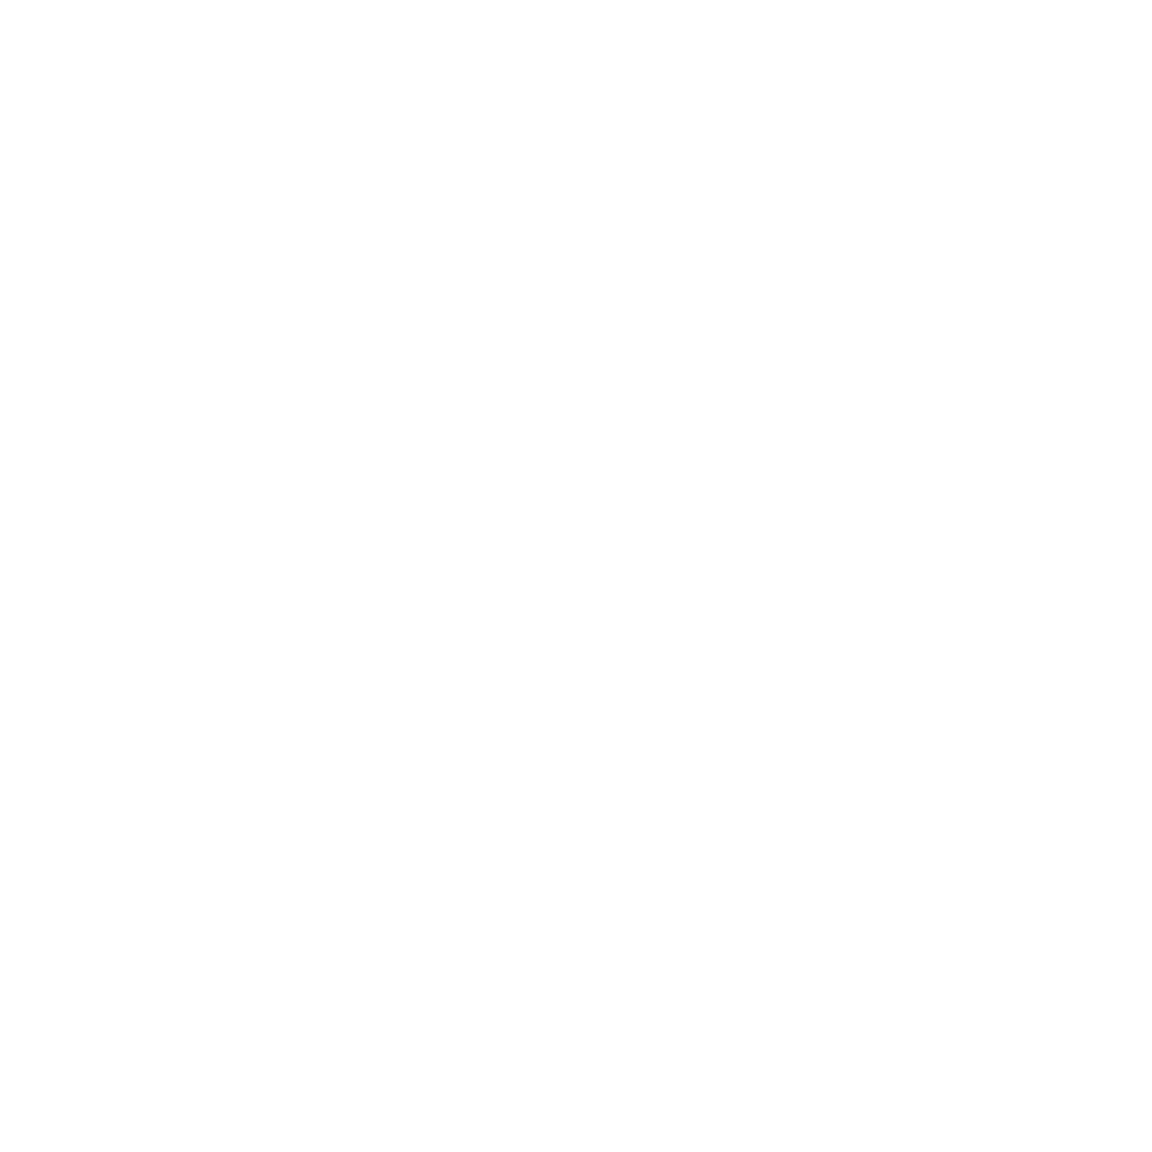

In [161]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
if True:
    examples = 10
    cimgs = imgs[sc.labels_ == 5]
    cimgs = cimgs[np.random.choice(cimgs.shape[0], examples)]

    fig, ax = plt.subplots(figsize=(10,10))
    ims = []

    hids = [ae.predict(cimgs[[i]])[0] for i in range(examples)]

    for i in range(examples):
        j = (i + 1) % examples
        interp = (decoder.predict(h) for h in interpolate(hids[i], hids[j], 10))
        ims.extend([[draw_frame(ax, i, "")] for i in interp])

    ani = animation.ArtistAnimation(fig, ims, interval=100)
    
#     
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save('rw_interpolation.mp4', writer=writer)

This is pretty expensive to compute and turns out to not give much insight to the clusters

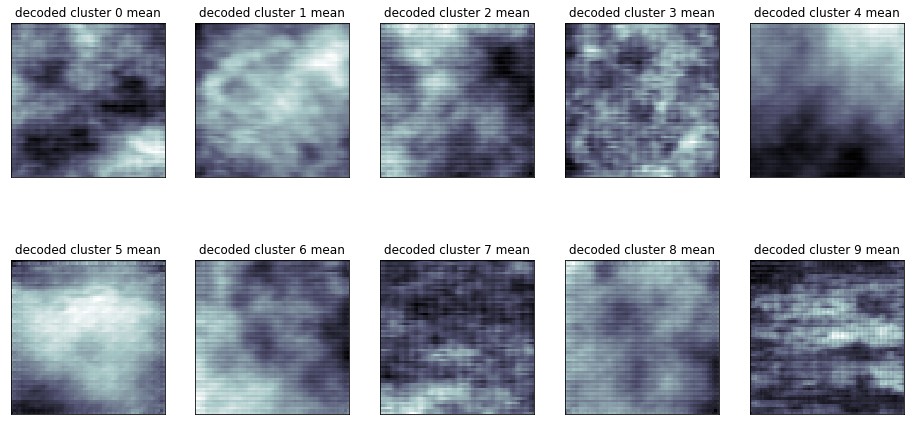

In [163]:
%matplotlib inline

examples = 50
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))

for i in range(10):
    cimgs = imgs[km.labels_ == i]
    cimgs = cimgs[np.random.choice(cimgs.shape[0], examples)]
    
    m = ae.predict(cimgs)[0]
    m = m.mean(axis=0)
    m = np.expand_dims(m, axis=0)
    m = decoder.predict(m)
    
    a = ax[i // 5, i % 5]
    a.set_title("decoded cluster %d mean"%i)
    a.imshow(m[0,:,:,0], cmap="bone")
    a.set_xticks([]); a.set_yticks([])

It seems taking the mean of the cluster and decoding does not produce meaningful results. This suggests that the AE latent manifold is not convex